# 序列模型

In [1]:
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

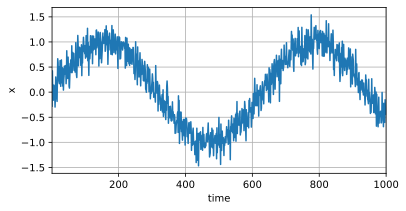

In [2]:
T = 1000
time = torch.arange(1, T+1, dtype=torch.float32)
x = torch.sin(time * 0.01) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [3]:
x.shape

torch.Size([1000])

In [4]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [5]:
features.shape, labels.shape

(torch.Size([996, 4]), torch.Size([996, 1]))

In [6]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [7]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.055790
epoch 2, loss: 0.052334
epoch 3, loss: 0.050118
epoch 4, loss: 0.051317
epoch 5, loss: 0.049381


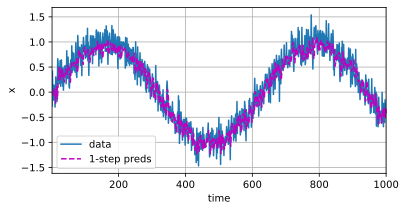

In [8]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

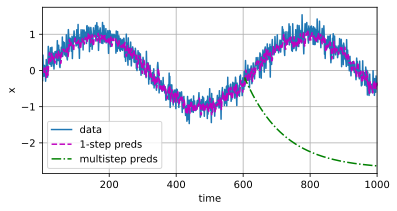

In [9]:
# 这里实现的是多步预测（multi-step prediction）。
# 从训练集（n_train + tau之前的数据）出发，利用前tau步的已知或已预测的值作为输入，
# 每次预测接下来的一个值，并将该预测结果继续作为后续输入，实现从n_train+tau往后的全部递推预测。
# 实际预测步数为 T - (n_train + tau)
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]  # 先用已有数据填充
for i in range(n_train + tau, T):
    # 每次用前tau个点的真实/预测值做输入，递归预测i时刻的值
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

In [11]:
# 基于 1 14 16 64进行预测
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
features.shape

torch.Size([933, 68])

In [12]:
for i in range(tau):
    features[:,i] = x[i:i+T-tau-max_steps+1]

In [13]:
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

tmp1[1]-shape: torch.Size([933])
tmp1[4]-shape: torch.Size([933])
tmp1[16]-shape: torch.Size([933])
tmp1[64]-shape: torch.Size([933])
tmp2[1]-shape: (933,)
tmp2[4]-shape: (933,)
tmp2[16]-shape: (933,)
tmp2[64]-shape: (933,)


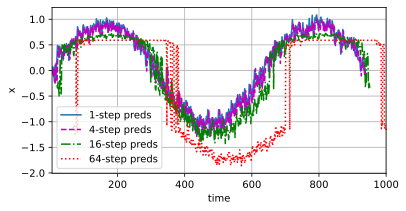

In [ ]:
import numpy as np
steps = (1, 4, 16, 64)

# 修复：显示 tmp1 和 tmp2 的具体内容及形状
tmp1 = [time[tau+i-1:T-max_steps+i] for i in steps]
tmp2 = [features[:, (tau+i-1)].detach().numpy() for i in steps]
for idx, arr in enumerate(tmp1):
    print(f'tmp1[{steps[idx]}]-shape:', np.shape(arr))
for idx, arr in enumerate(tmp2):
    print(f'tmp2[{steps[idx]}]-shape:', np.shape(arr))

d2l.plot(
    tmp1,
    tmp2,
    'time', 'x',
    legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
    figsize=(6, 3)
)